# orthomap: Step 2 - gene age class assignment

This notebook will demonstrate how to extract an orthomap (gene age class) from [OrthoFinder](https://orthomap.readthedocs.io/en/latest/tutorials/https://github.com/davidemms/OrthoFinder) results or how to import pre-calculated orthomaps.

## Notebook file

Notebook file can be obtained here:

[https://raw.githubusercontent.com/kullrich/orthomap/main/docs/notebooks/get_orthomap.ipynb](https://raw.githubusercontent.com/kullrich/orthomap/main/docs/notebooks/get_orthomap.ipynb)

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
# increase dpi
%matplotlib inline
#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = [6, 4.5]
#plt.rcParams['figure.figsize'] = [4.4, 3.3]

## Import orthomap python package submodules

In [2]:
# import submodules
from orthomap import qlin, gtf2t2g, of2orthomap, orthomap2tei, datasets

## Use OrthoFinder results to get gene age classification

The query species in this part is: __*Danio rerio*__ (zebrafish).

Please have a look at the documentation of [Step 0 - run OrthoFinder](https://orthomap.readthedocs.io/en/latest/tutorials/orthofinder.html) to get to know what information and files are mandatory to extract gene age classes from [OrthoFinder](https://orthomap.readthedocs.io/en/latest/tutorials/https://github.com/davidemms/OrthoFinder) results.

__Mandatory query species information:__

- query species sequence name (see header of <Orthogroups.GeneCount.tsv> or <Orthogroups.tsv> file) (`seqname=`)
- query species taxonomic ID (`qt=`)

__Mandatory information from [OrthoFinder](https://orthomap.readthedocs.io/en/latest/tutorials/https://github.com/davidemms/OrthoFinder) run:__

- tab delimted file containing sequence name and taxonomic IDs of all species used (`<OrthoFinder name><tab><species taxID>`) (`sl=`)

__Mandatory files from [OrthoFinder](https://orthomap.readthedocs.io/en/latest/tutorials/https://github.com/davidemms/OrthoFinder):__

- <Orthogroups.GeneCount.tsv> or <Orthogroups.GeneCount.tsv.zip> (`oc=`)
- <Orthogroups.tsv> or <Orthogroups.tsv.zip> (`og=`)

In [Step 1 - get taxonomic information](https://orthomap.readthedocs.io/en/latest/tutorials/query_lineage.html) you have already been introduced how to extract query lineage information with `orthomap` and the `qlin.get_qlin()` function.

In [3]:
# get query species taxonomic lineage information
query_lineage = qlin.get_qlin(q='Danio rerio')

query name: Danio rerio
query taxID: 7955
query kingdom: Eukaryota
query lineage names: 
['root(1)', 'cellular organisms(131567)', 'Eukaryota(2759)', 'Opisthokonta(33154)', 'Metazoa(33208)', 'Eumetazoa(6072)', 'Bilateria(33213)', 'Deuterostomia(33511)', 'Chordata(7711)', 'Craniata(89593)', 'Vertebrata(7742)', 'Gnathostomata(7776)', 'Teleostomi(117570)', 'Euteleostomi(117571)', 'Actinopterygii(7898)', 'Actinopteri(186623)', 'Neopterygii(41665)', 'Teleostei(32443)', 'Osteoglossocephalai(1489341)', 'Clupeocephala(186625)', 'Otomorpha(186634)', 'Ostariophysi(32519)', 'Otophysi(186626)', 'Cypriniphysae(186627)', 'Cypriniformes(7952)', 'Cyprinoidei(30727)', 'Danionidae(2743709)', 'Danioninae(2743711)', 'Danio(7954)', 'Danio rerio(7955)']
query lineage: 
[1, 131567, 2759, 33154, 33208, 6072, 33213, 33511, 7711, 89593, 7742, 7776, 117570, 117571, 7898, 186623, 41665, 32443, 1489341, 186625, 186634, 32519, 186626, 186627, 7952, 30727, 2743709, 2743711, 7954, 7955]


For this documentation part all mandatory [OrthoFinder](https://orthomap.readthedocs.io/en/latest/tutorials/https://github.com/davidemms/OrthoFinder) ([Emms and Kelly, 2019](https://doi.org/10.1186/s13059-019-1832-y)) results have been pre-calculated. 

[OrthoFinder](https://orthomap.readthedocs.io/en/latest/tutorials/https://github.com/davidemms/OrthoFinder) was run with the option `-S diamond_ultra_sens` using translated, longest-isoform coding sequences (CDS) from [Ensembl release-105](https://ftp.ensembl.org/pub/release-105/) including species taxonomic IDs.

The results are available here: 

https://doi.org/10.5281/zenodo.7242264

or can be accessed with the `dataset` submodule of `orthomap`

`datasets.ensembl105(datapath='data')` (download folder set to `'data'`).

__Note:__ If you want to use your own [OrthoFinder](https://orthomap.readthedocs.io/en/latest/tutorials/https://github.com/davidemms/OrthoFinder) results, please have a look at the documentation of [Step 0 - run OrthoFinder](https://orthomap.readthedocs.io/en/latest/tutorials/orthofinder.html).

In [4]:
datasets.ensembl105(datapath='data')

100% [..............................................................................] 15662 / 15662

['data/ensembl_105_orthofinder_Orthogroups.GeneCount.tsv.zip',
 'data/ensembl_105_orthofinder_Orthogroups.tsv.zip',
 'data/ensembl_105_orthofinder_species_list.tsv']

Here, `orthomap` use the query species information and [OrthoFinder](https://orthomap.readthedocs.io/en/latest/tutorials/https://github.com/davidemms/OrthoFinder) results to extract the oldest common tree node per orthogroup along a species tree and to assign this node as the gene age to the corresponding genes.

In a pairwise manner, the query species and any other species in the [OrthoFinder](https://orthomap.readthedocs.io/en/latest/tutorials/https://github.com/davidemms/OrthoFinder) result might share multiple tree nodes down to the root of the species tree, but have only one youngest tree node in common. Among all possible comparison between the query species and the other species, the oldest as defined by the species tree root is selected and used for the gene age assignment.

Given the `query species sequence name` (`seqname=`) used in the [OrthoFinder](https://orthomap.readthedocs.io/en/latest/tutorials/https://github.com/davidemms/OrthoFinder) comparison, the `query species taxonomic ID`(`qt=`), the `taxonomic IDs of all species` from the <species_list.tsv> file (`sl=`) used in the [OrthoFinder](https://orthomap.readthedocs.io/en/latest/tutorials/https://github.com/davidemms/OrthoFinder) comparison, the `orthogroup gene count` <Orthogroups.GeneCount.tsv> file (`oc=`) results and the `orthogroups` <Orthogroups.tsv> file (`og=`), an orthomap is constructed.

__Note:__ This step can take up to five minutes, depending on your hardware.

For this step to get the query species orthomap, one uses the `of2orthomap.get_orthomap()` function, like:

In [5]:
# get query species orthomap

# download orthofinder results here: https://doi.org/10.5281/zenodo.7242264
# or download with datasets.ensembl105('data')
query_orthomap, orthofinder_species_list, of_species_abundance = of2orthomap.get_orthomap(
    seqname='Danio_rerio.GRCz11.cds.longest',
    qt='7955',
    sl='data/ensembl_105_orthofinder_species_list.tsv',
    oc='data/ensembl_105_orthofinder_Orthogroups.GeneCount.tsv.zip',
    og='data/ensembl_105_orthofinder_Orthogroups.tsv.zip',
    continuity=True)
query_orthomap

Danio_rerio.GRCz11.cds.longest
Danio rerio
7955
                                               species    taxID  \
0    Acanthochromis_polyacanthus.ASM210954v1.cds.lo...    80966   
1    Accipiter_nisus.Accipiter_nisus_ver1.0.cds.lon...   211598   
2       Ailuropoda_melanoleuca.ASM200744v2.cds.longest     9646   
3             Amazona_collaria.ASM394721v1.cds.longest   241587   
4         Amphilophus_citrinellus.Midas_v5.cds.longest    61819   
..                                                 ...      ...   
307  Xiphophorus_couchianus.Xiphophorus_couchianus-...    32473   
308  Xiphophorus_maculatus.X_maculatus-5.0-male.cds...     8083   
309    Zalophus_californianus.mZalCal1.pri.cds.longest     9704   
310  Zonotrichia_albicollis.Zonotrichia_albicollis-...    44394   
311  Zosterops_lateralis_melanops.ASM128173v1.cds.l...  1220523   

                                               lineage  youngest_common  \
0    [1, 131567, 2759, 33154, 33208, 6072, 33213, 3...           186625 

,seqID,Orthogroup,PSnum,PStaxID,PSname,PScontinuity
0,ENSDART00000127643.3,OG0000000,6,33213,Bilateria,0.846154
1,ENSDART00000171750.2,OG0000000,6,33213,Bilateria,0.846154
2,ENSDART00000190648.1,OG0000000,6,33213,Bilateria,0.846154
3,ENSDART00000130167.3,OG0000001,10,7742,Vertebrata,0.909091
4,ENSDART00000150909.2,OG0000001,10,7742,Vertebrata,0.909091
...,...,...,...,...,...,...
25167,ENSDART00000180796.1,OG0029510,19,186625,Clupeocephala,0.400000
25168,ENSDART00000145618.2,OG0029511,19,186625,Clupeocephala,0.400000
25169,ENSDART00000143229.2,OG0029512,29,7955,Danio rerio,1.000000
25170,ENSDART00000143837.3,OG0029512,29,7955,Danio rerio,1.000000


### Gene age assignments per query species lineage node

Given an orthomap, one can get an overview of the gene age assignments per query species lineage node.

The `orthomap` submodule `of2orhomap` and the `of2orthomap.get_counts_per_ps()` function will show the distribution of the gene age classes and can be further visualized as follows:

In [6]:
# show count per taxonomic group (PStaxID)
of2orthomap.get_counts_per_ps(query_orthomap)

,PSnum,counts,PStaxID,PSname
PSnum,,,,
3,3,5209,33154,Opisthokonta
6,6,10495,33213,Bilateria
8,8,2869,7711,Chordata
10,10,2586,7742,Vertebrata
11,11,1257,7776,Gnathostomata
13,13,817,117571,Euteleostomi
14,14,380,7898,Actinopterygii
16,16,184,41665,Neopterygii
18,18,163,1489341,Osteoglossocephalai


### Visualize number of species along query lineage and counts per gene age class

<AxesSubplot: >

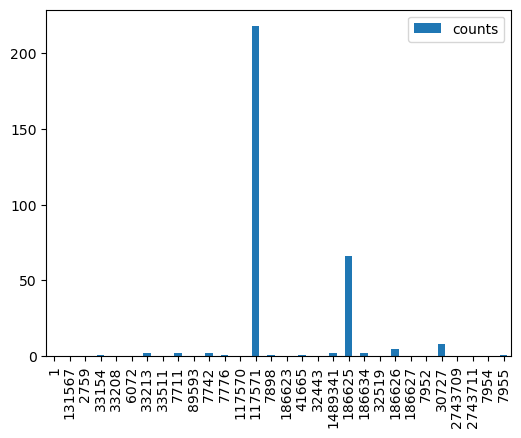

In [7]:
# show number of species along query lineage
of_species_abundance

# bar plot number of species along query lineage
of_species_abundance.plot.bar(y='counts', use_index=True)

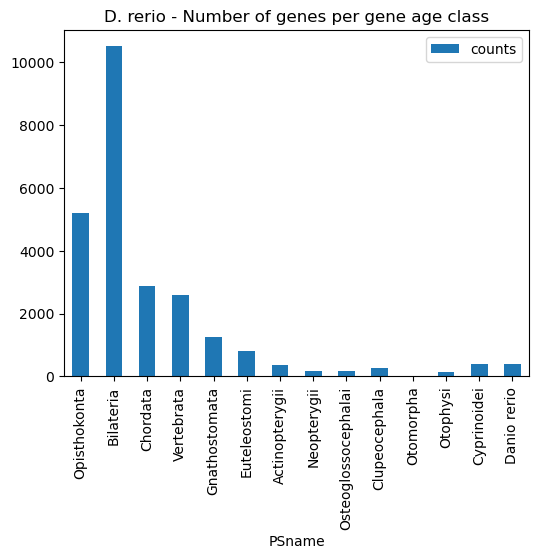

In [8]:
# show count per taxonomic group (PStaxID)
of2orthomap.get_counts_per_ps(query_orthomap)

# bar plot count per taxonomic group (PSname)
ax = of2orthomap.get_counts_per_ps(query_orthomap).plot.bar(y='counts', x='PSname')
ax.set_title('D. rerio - Number of genes per gene age class')
plt.show()

## Use pre-calculated gene age classification

The query species in this part is: __*Caenorhabditis elegans*__ (nematode).

Any pre-calculated gene age classification can be imported as a table using the function `orthomap2tei.read_orthomap(orthomapfile=filename)`.

The pre-calculated gene age classification file should be <tab> delimited with two columns `GeneID<tab>Phylostratum`, like e.g.:
    
```
GeneID<tab>Phylostratum
WBGene00000001<tab>1
WBGene00000002<tab>1
WBGene00000003<tab>1
WBGene00000004<tab>1
WBGene00000005<tab>2
```

The orthomap for this part was pre-calculated ([Sun et al., 2021](https://doi.org/10.1101/gr.275303.121)) and is available here:

[https://doi.org/10.5281/zenodo.7242263](https://doi.org/10.5281/zenodo.7242263)

or can be accessed with the `dataset` submodule of `orthomap`

`datasets.sun21_orthomap(datapath='data')` (download folder set to `'data'`).

__Note:__ If you want to use your own [OrthoFinder](https://orthomap.readthedocs.io/en/latest/tutorials/https://github.com/davidemms/OrthoFinder) results, please have a look at the documentation of [Step 0 - run OrthoFinder](https://orthomap.readthedocs.io/en/latest/tutorials/orthofinder.html).

A detailed description of how to extract an orthomap from [OrthoFinder](https://orthomap.readthedocs.io/en/latest/tutorials/https://github.com/davidemms/OrthoFinder) results is described in the first part.

In [9]:
datasets.sun21_orthomap(datapath='data')

100% [............................................................................] 344640 / 344640

'data/Sun2021_Orthomap.tsv'

In [10]:
# get query species taxonomic lineage information
query_lineage = qlin.get_qlin(q='Caenorhabditis elegans')

query name: Caenorhabditis elegans
query taxID: 6239
query kingdom: Eukaryota
query lineage names: 
['root(1)', 'cellular organisms(131567)', 'Eukaryota(2759)', 'Opisthokonta(33154)', 'Metazoa(33208)', 'Eumetazoa(6072)', 'Bilateria(33213)', 'Protostomia(33317)', 'Ecdysozoa(1206794)', 'Nematoda(6231)', 'Chromadorea(119089)', 'Rhabditida(6236)', 'Rhabditina(2301116)', 'Rhabditomorpha(2301119)', 'Rhabditoidea(55879)', 'Rhabditidae(6243)', 'Peloderinae(55885)', 'Caenorhabditis(6237)', 'Caenorhabditis elegans(6239)']
query lineage: 
[1, 131567, 2759, 33154, 33208, 6072, 33213, 33317, 1206794, 6231, 119089, 6236, 2301116, 2301119, 55879, 6243, 55885, 6237, 6239]


In [11]:
# get query species orthomap

# download pre-calculated orthomap here: https://doi.org/10.5281/zenodo.7242263
# or download with datasets.sun21_orthomap(datapath='data')
query_orthomap = orthomap2tei.read_orthomap(orthomapfile='data/Sun2021_Orthomap.tsv')
query_orthomap

,GeneID,Phylostratum
0,WBGene00000001,1
1,WBGene00000002,1
2,WBGene00000003,1
3,WBGene00000004,1
4,WBGene00000005,2
...,...,...
20035,WBGene00305132,9
20036,WBGene00305157,1
20037,WBGene00305158,13
20038,WBGene00305159,11


### Gene age assignments per query species lineage node

Given a pre-calculated orthomap, one can still get an overview of the gene age assignments per query species lineage node.

However, since it might be that some columns are missing which normally are produced by the `of2orthomap.get_orthomap()`function, the column names need to be set specifically with the `of2orthomap.get_counts_per_ps()` function to visualize the distribution of the gene age classes as follows:

In [12]:
# show count per taxonomic group (Phylostratum)
of2orthomap.get_counts_per_ps(omap_df=query_orthomap,
    psnum_col='Phylostratum',
    pstaxid_col=None,
    psname_col=None)

,Phylostratum,counts
Phylostratum,,
0,0,1290
1,1,5434
2,2,4666
3,3,603
4,4,1039
5,5,808
6,6,274
7,7,884
8,8,590


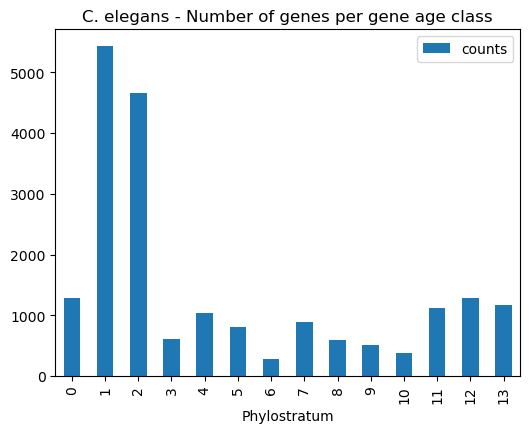

In [13]:
# bar plot count per taxonomic group (Phylostratum)
ax = of2orthomap.get_counts_per_ps(omap_df=query_orthomap,
    psnum_col='Phylostratum',
    pstaxid_col=None,
    psname_col=None).plot.bar(y='counts', x='Phylostratum')
ax.set_title('C. elegans - Number of genes per gene age class')
plt.show()

If you like to continue, please have a look at the documentation of [Step 3 - map gene/transcript IDs](https://orthomap.readthedocs.io/en/latest/tutorials/geneset_overlap.html) to get further insides.